# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

In [52]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
#from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [53]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [54]:
# local or gdrive
path_source = 'work'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

In [55]:
# decide whether to save results:
save_results = False

# Read in data

In [56]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-18.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

# Data clean

In [57]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (not needed), we actually multiply year trend by county_month
# df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

Function to get a simpler model output

In [58]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

#get_ols_res(fit1).head(1)

# First stage regression - Predict pm2.5 levels

One hot encode

In [59]:
cols_to_encode = ['school_county_v2', 'month', 'county_month']
numeric_FE = ['dist_school_to_ps_m', 'point_source_pm25_tpy', 'nearby_point_source_count', 'school_count', 'avg_wind_speed', 
  'ca_agi_per_returns', 'school_temperature', 'ps_temperature', 'year_trend']
instrum = ['avg_wind_alignment_cosine']

enc1 = OneHotEncoder(handle_unknown = 'ignore')
enc1.fit(df[cols_to_encode])

if save_results:
  enc_file = os.path.join(data_path, '../fitted_models/onehotencoder')
  import pickle
  with open(enc_file, "wb") as f: 
    pickle.dump(enc1, f)

# Load it back in like this:
# with open(enc_file, "rb") as f: 
#   enc = pickle.load(f)


df_encoded = pd.DataFrame(enc1.transform(df[cols_to_encode]).toarray())

all_cols = []
for i,col in enumerate(cols_to_encode):
  res1 = [col+'_'+j for j in enc1.categories_[i]]
  all_cols += res1

df_encoded.columns = all_cols
df_encoded.columns = df_encoded.columns.str.replace("\.*\s+", "_").str.lower()

# drop baseline columns
df_encoded = df_encoded.drop(columns = ['school_county_v2_los_angeles', 'month_1', 'county_month_01_los_angeles'])

In [60]:
# get data into right model form
# add intercept, instrument, numeric fixed effects, and encoded columns
y = df['pm25']
df['intercept'] = 1
X = pd.concat([df[instrum + numeric_FE + ['intercept']], df_encoded], axis=1)

# next, create year_trend * county_month field
county_month_cols = [i for i in X.columns if re.search('county_month_', i)]
for col in county_month_cols:
  X['year_trend_'+col] = X['year_trend'] * X[col]

/var/folders/mp/gc4psx7d21v2d969fdlnvpmm0000gn/T/ipykernel_13125/2402485792.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['year_trend_'+col] = X['year_trend'] * X[col]
/var/folders/mp/gc4psx7d21v2d969fdlnvpmm0000gn/T/ipykernel_13125/2402485792.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X['year_trend_'+col] = X['year_trend'] * X[col]
/var/folders/mp/gc4psx7d21v2d969fdlnvpmm0000gn/T/ipykernel_13125/2402485792.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [61]:
# fit model
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# save model
if save_results:
  fit1.save(os.path.join(fitted_models_path, 'stage1_ols.pickle'), remove_data=True)

# Get residuals
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

# calculate r^2
ss_resid = sum((df['yhat_pm25'].values - df['pm25'].values)**2)
ss_total = sum((df['pm25'].mean() - df['pm25'].values)**2)
r_squared = 1 - ss_resid / ss_total 
print('r squared: {:.4f}'.format(r_squared))

get_ols_res(fit1).head(3)

r squared: 0.5072


,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.126624,1.889751e-21,0.100532,0.152716
1,dist_school_to_ps_m,-0.000078,0.000000e+00,-0.000080,-0.000077
2,point_source_pm25_tpy,-0.003710,2.668523e-152,-0.003987,-0.003434


# Second Stage Regression

- Stage 1 of the least squares regression: $\widehat{PM}_{2.5}=\beta_0 + \beta_1 \theta_{downstream} + \beta_{2}year + \beta_{3}month + \beta_{4}county + \epsilon$
  - $\theta_{downstream}$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 

- Stage 2 of the equation: $Y=\frac{\sum diagnoses}{Pop_{zipcode, 0-19}}=\delta_0 + \delta_1 \widehat{PM}_{2.5} + \delta_{2}year + \delta_{3}month + \delta_{4}county + \epsilon$


In addition to this two stage framework, also run the stage 2 regression using true pm2.5 values. So we can see how biased the coefficient is. 

In [62]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns='avg_wind_alignment_cosine')
X['yhat_pm25'] = df['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front
X_truepm25 = pd.concat([df['pm25'], X.drop(columns='yhat_pm25')], axis = 1)

In [63]:
# fit model
fit2_hema = sm.OLS(df['y_hematopoietic'], X).fit()

# save model
if save_results:
  fit2_hema.save(os.path.join(fitted_models_path, 'stage2_ols_hematopoietic.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

# Get residuals
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_hema).head(1))

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df['y_hematopoietic'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.100868  0.066402    -0.006828     0.208565

true pm2.5:
  variable      coef  p_value  95_ci_lower  95_ci_upper
0     pm25 -0.001279  0.17311    -0.003119     0.000561


In [64]:
# fit model
fit2_vasc = sm.OLS(df['y_vasculitis'], X).fit()

# save model
if save_results:
  fit2_vasc.save(os.path.join(fitted_models_path, 'stage2_ols_vasculitis.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# Get residuals
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_vasc).head(1))

# fit model with true pm2.5
fit2_vasc_truepm2 = sm.OLS(df['y_vasculitis'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm2).head(1))

yhat pm2.5:
    variable      coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.084259  0.01914    -0.154749    -0.013768

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.002089  0.000677    -0.003293    -0.000884


In [65]:
# fit model
fit2_diab = sm.OLS(df['y_diabetes'], X).fit()

# save model
if save_results:
  fit2_diab.save(os.path.join(fitted_models_path, 'stage2_ols_diabetes.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_diabetes'] = fit2_diab.fittedvalues.values

# Get residuals
resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_diab).head(1))

# fit model with true pm2.5
fit2_diab_truepm2 = sm.OLS(df['y_diabetes'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm2).head(1))

yhat pm2.5:
    variable    coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.1118  0.44766     -0.40038      0.17678

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.006105  0.015245    -0.011036    -0.001174


In [66]:
# fit model
fit2_resp_cardio = sm.OLS(df['y_resp_cardio'], X).fit()

# save model
if save_results:
  fit2_resp_cardio.save(os.path.join(fitted_models_path, 'stage2_ols_resp_cardio.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

# Get residuals
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_resp_cardio).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm2 = sm.OLS(df['y_resp_cardio'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm2).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  4.352866  0.716178   -19.112948     27.81868

true pm2.5:
  variable     coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.81773  0.000064    -1.218691     -0.41677


In [67]:
# fit model
fit2_injuries = sm.OLS(df['y_injuries'], X).fit()

# save model
if save_results:
  fit2_injuries.save(os.path.join(fitted_models_path, 'stage2_ols_injuries.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_injuries'] = fit2_injuries.fittedvalues.values

# Get residuals
resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_injuries).head(1))

# fit model with true pm2.5
fit2_injuries_truepm2 = sm.OLS(df['y_injuries'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm2).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  28.18064  0.015838     5.287337    51.073944

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.808092  0.000051    -1.199274     -0.41691


## All results

In [68]:
all_res_yhat = [get_ols_res(x).head(1) for x in [fit2_hema, fit2_vasc, fit2_diab, fit2_resp_cardio, fit2_injuries]]
all_res_true = [get_ols_res(x).head(1) for x in [fit2_hema_truepm25, fit2_vasc_truepm2, fit2_diab_truepm2, fit2_resp_cardio_truepm2, fit2_injuries_truepm2]]

all_res_yhat = pd.concat(all_res_yhat)
all_res_true = pd.concat(all_res_true)

print("Stage 1 results:")
print(get_ols_res(fit1).head(1))


print("\nStage 2 results:")
df_res = pd.DataFrame({
  'yvar': ['hematopoietic', 'vasculitis', 'diabetes', 'respiratory', 'injuries']
  
  ,'coef_pm25_yhat': all_res_yhat['coef'].values
  ,'pvalue_pm25_yhat': all_res_yhat['p_value'].values
  ,'ci95_lower_pm25_yhat': all_res_yhat['95_ci_lower'].values
  ,'ci95_upper_pm25_yhat': all_res_yhat['95_ci_upper'].values

  ,'coef_pm25_true': all_res_true['coef'].values
  ,'pvalue_pm25_true': all_res_true['p_value'].values
  ,'ci95_lower_pm25_true': all_res_true['95_ci_lower'].values
  ,'ci95_upper_pm25_true': all_res_true['95_ci_upper'].values
})
df_res

Stage 1 results:
                    variable      coef       p_value  95_ci_lower  95_ci_upper
0  avg_wind_alignment_cosine  0.126624  1.889751e-21     0.100532     0.152716

Stage 2 results:


,yvar,coef_pm25_yhat,pvalue_pm25_yhat,ci95_lower_pm25_yhat,ci95_upper_pm25_yhat,coef_pm25_true,pvalue_pm25_true,ci95_lower_pm25_true,ci95_upper_pm25_true
0,hematopoietic,0.100868,0.066402,-0.006828,0.208565,-0.001279,0.173110,-0.003119,0.000561
1,vasculitis,-0.084259,0.019140,-0.154749,-0.013768,-0.002089,0.000677,-0.003293,-0.000884
2,diabetes,-0.111800,0.447660,-0.400380,0.176780,-0.006105,0.015245,-0.011036,-0.001174
3,respiratory,4.352866,0.716178,-19.112948,27.818680,-0.817730,0.000064,-1.218691,-0.416770
4,injuries,28.180640,0.015838,5.287337,51.073944,-0.808092,0.000051,-1.199274,-0.416910


# Save data with results

In [ ]:
if save_results:
  df.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_results_2022-10-27.csv'), index=False)

# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


                    wind_bearing   hema_resids   vasc_resids   diab_resids  \
wind_bearing        1.000000e+00  8.377870e-13 -1.024658e-12 -3.277859e-13   
hema_resids         8.377870e-13  1.000000e+00  2.051566e-02  5.578265e-04   
vasc_resids        -1.024658e-12  2.051566e-02  1.000000e+00  7.106334e-04   
diab_resids        -3.277859e-13  5.578265e-04  7.106334e-04  1.000000e+00   
resp_cardio_resids  9.336487e-14  6.597216e-03  5.940369e-03  6.177999e-02   
injuries_resids     1.029659e-12  4.793952e-03  2.600049e-03  3.419457e-02   

                    resp_cardio_resids  injuries_resids  
wind_bearing              9.336487e-14     1.029659e-12  
hema_resids               6.597216e-03     4.793952e-03  
vasc_resids               5.940369e-03     2.600049e-03  
diab_resids               6.177999e-02     3.419457e-02  
resp_cardio_resids        1.000000e+00     9.534865e-02  
injuries_resids           9.534865e-02     1.000000e+00  


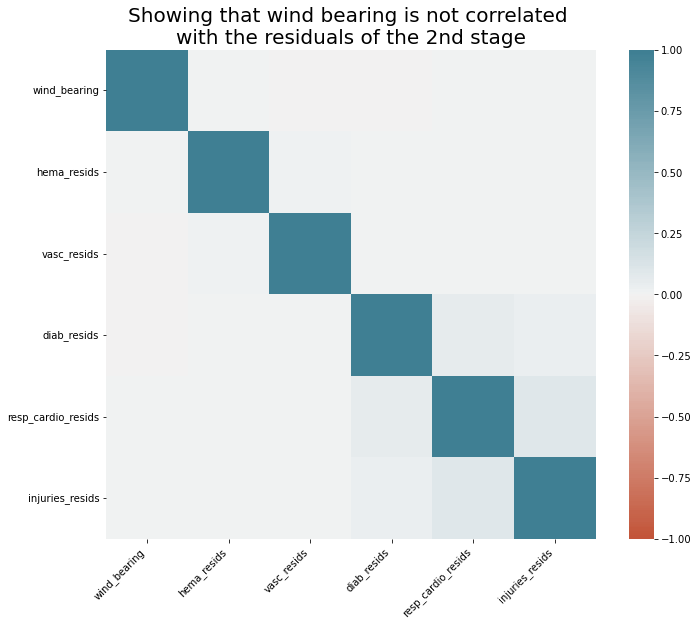

In [69]:
df_corr = pd.DataFrame({
  'wind_bearing': df['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values,
  'resp_cardio_resids': resids_and_fitted_resp_cardio.resids.values,
  'injuries_resids': resids_and_fitted_injuries.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [70]:
# get data into right model form
y, X_null = dmatrices('pm25 ~ 1', data=df, return_type='dataframe')
y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,311162.0,1.114428e+07,0.0,NaN,NaN,NaN
1,311161.0,1.114275e+07,1.0,1526.706847,42.633231,6.612902e-11
